# Linear Bivariate BMM with SAMBA toy models : switchcos mixing

The best way to learn Taweret is to use it. You can run, modify and experiment with this notebook [here.](https://mybinder.org/v2/gh/danOSU/Taweret/c2d8fd3ce3d74a5891d51adb5afc0afa0b503127?urlpath=lab%2Ftree%2Fdocs%2Fsource%2Fnotebooks%2FLinear_BMM_with_switchcos_function_for_SAMBA_models.ipynb)


This notebook try to reproduce the work by **A. C. Semposki, R. J. Furnstahl, D. R. Phillips** in  [Uncertainties here, there, and everywhere: interpolating between small- and large-g expansions using Bayesian Model Mixing](https://arxiv.org/abs/2206.04116) using the Bayesian model mixing package **Taweret**. 

**Author : Dan Liyanage**

Date : 11/10/2022

More about SAMBA toy models can be found in [Uncertainties here, there, and everywhere: interpolating between small- and large-g expansions using Bayesian Model Mixing](https://arxiv.org/abs/2206.04116)



**Steps for Bayesian Model Mixing with Taweret**

    1. Define your models using BayesModel class in `Taweret.core.bayesmodel` (Only if you want to bring in your own models)
    2. Choose a Mixing method (Avilable mixing methods can be found in Taweret/mix)
    3. Find the posterior for the mixture weights (parameters in the mixture function) and/or model parameters by training the mixed model. 
    4. Make predictions! 

In [1]:
import sys

# You will have to change the following imports depending on where you have 
# the packages installed
# If using binder please uncomment the followings.
#sys.path.append("/home/jovyan/")
#sys.path.append("/home/jovyan/subpackages/SAMBA")

sys.path.append("/Users/dananjayaliyanage/temp2/Taweret")
sys.path.append("/Users/dananjayaliyanage/temp2/Taweret/subpackages/SAMBA")

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('poster')
# To define priors. (uncoment if not using default priors)
import bilby

# For other operations
import numpy as np

## 1. Get toy models and the pseudo-experimental data

In [2]:
# Toy models from SAMBA
from Taweret.models import samba_models as toy_models

m1 = toy_models.Loworder(2, 'uninformative')
m2 = toy_models.Highorder(2, 'uninformative')
truth = toy_models.TrueModel()
exp = toy_models.Data()



In [3]:
g = np.linspace(0.1, 0.6, 10)
plot_g = np.linspace(0.01,1,100)
m1_prediction = m1.evaluate(plot_g)
m2_prediction = m2.evaluate(plot_g)
true_output = truth.evaluate(plot_g)
exp_data= exp.evaluate(g,error = 0.01)

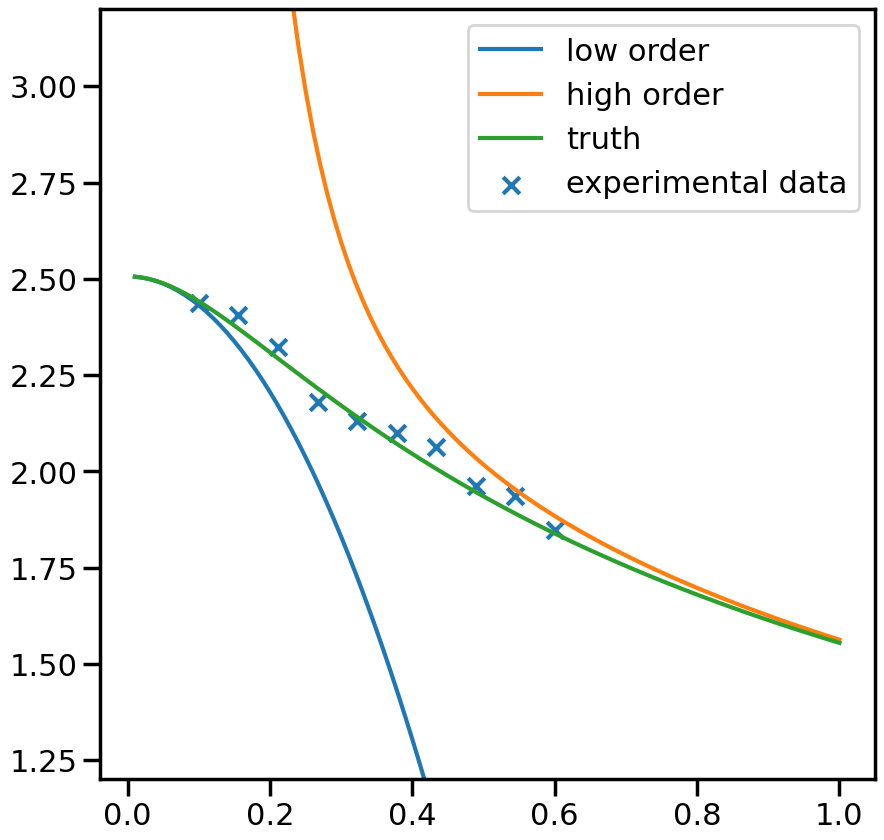

In [4]:

fig, ax_f = plt.subplots(figsize=(10,10))
ax_f.plot(plot_g, m1_prediction[0].flatten(), label='low order')
ax_f.plot(plot_g, m2_prediction[0].flatten(), label='high order')
ax_f.plot(plot_g, true_output[0], label='truth')
ax_f.scatter(g,exp_data[0], marker='x', label='experimental data')
ax_f.set_ylim(1.2,3.2)
ax_f.legend()

###  2. Choose a Mixing method

In [5]:
# Mixing method
from Taweret.mix.bivariate_linear import BivariateLinear as BL

models= {'low_order':m1,'high_order':m2}
mix_model = BL(models_dic=models, method='switchcos') 

switchcos mixing function has 3                   free parameter(s)
To change the prior use `set_prior` method


#####  Need to speceify a constained prior for switchcos. g1 < g3 < g2
We follow Bilby documentation on how to specefy a prior with constraints
https://lscsoft.docs.ligo.org/bilby/prior.html#prior-constraints

In [6]:
# from scipy import stats 

# def luniform(theta, a, b):

#     if theta > a and theta < b:
#         return 0.0
#     else:
#         return -np.inf

# def lpdf(params):
#     if len(params) == 3:
#         #g1 truncated between (0, 0.35) 
#         g1 = luniform(params[0], 0.01, 0.3) + stats.norm.logpdf(params[0], 0.1, 0.05)   #0.1 for 2 v 2, #0.1 for 5 v 5
#         #g3 truncated between (g1, 0.35)
#         g3 = luniform(params[2], params[0], 0.55) + stats.norm.logpdf(params[2], 0.4, 0.05)   #0.4 for 2 v 2, #0.25 for 5 v 5
#         #g2 truncated between (g3, 0.35)
#         g2 = luniform(params[1], params[2], 0.8) + stats.norm.logpdf(params[1], 0.6, 0.05)  #0.6 for 2 v 2, #0.4 for 5 v 5
#         return (g1 + g2 + g3)
#     else:
#         print(params)
#         raise ValueError('The number of parameters does not match any available switching function.')

In [7]:
from bilby.core.prior.joint import BaseJointPriorDist, JointPrior, JointPriorDistError
from samba.priors import Priors as samba_P
samba_prior = samba_P()


class custom_prior_switchcos(BaseJointPriorDist):
    def __init__(self, names, bounds=None):
        '''
        A class defining prior for swithcos mixing method

        Parameters
        ==========
        names: list
            A list of the parameter names in the prior
        '''
        super().__init__(names=names, bounds=bounds)
        self.names=names
    def ln_prob(self,value):
        try:
            n_sam = value.shape[1]
            return [samba_prior.lpdf(x) for x in value]
        except:
            return samba_prior.lpdf(value)

    def _sample(self, size, **kwargs):
        """
        Draw, and set, a sample for the switchcos parameter joint distribution

        Parameters
        ==========
        size: int
            number of samples to generate, defaults to 1
        """
        samps = np.zeros((size, len(self)))
        samps[:,0] = np.random.uniform(0.12, 0.18, size)
        samps[:,2] = np.random.uniform(0.19, 0.24, size)
        samps[:,1] = np.random.uniform(0.25, 0.30, size)

        return samps

class prior_switchcos(JointPrior):
    def __init__(self, dist, name=None, latex_label=None, unit=None):
        if not isinstance(dist, custom_prior_switchcos):
            raise JointPriorDistError("dist object must be instance of custom_prior_switchcos")
        super().__init__(dist=dist, name=name, latex_label=latex_label, unit=unit)

mvg = custom_prior_switchcos(names=['switchcos_0', 'switchcos_1', 'switchcos_2'], bounds=[[0.0,0.35],[0.0,0.35],[0.0,0.35]])
priors = bilby.core.prior.PriorDict()
priors['switchcos_0'] = prior_switchcos(mvg,'switchcos_0')
priors['switchcos_1'] = prior_switchcos(mvg,'switchcos_1')
priors['switchcos_2'] = prior_switchcos(mvg,'switchcos_2')


In [8]:
mix_model.set_prior(priors)

{'switchcos_0': __main__.prior_switchcos(dist=custom_prior_switchcos(names=['switchcos_0', 'switchcos_1', 'switchcos_2'], bounds={'switchcos_0': (0.0, 0.35), 'switchcos_1': (0.0, 0.35), 'switchcos_2': (0.0, 0.35)}), name='switchcos_0', latex_label='switchcos_0', unit=None),
 'switchcos_1': __main__.prior_switchcos(dist=custom_prior_switchcos(names=['switchcos_0', 'switchcos_1', 'switchcos_2'], bounds={'switchcos_0': (0.0, 0.35), 'switchcos_1': (0.0, 0.35), 'switchcos_2': (0.0, 0.35)}), name='switchcos_1', latex_label='switchcos_1', unit=None),
 'switchcos_2': __main__.prior_switchcos(dist=custom_prior_switchcos(names=['switchcos_0', 'switchcos_1', 'switchcos_2'], bounds={'switchcos_0': (0.0, 0.35), 'switchcos_1': (0.0, 0.35), 'switchcos_2': (0.0, 0.35)}), name='switchcos_2', latex_label='switchcos_2', unit=None)}

### 3. Train to find posterior

In [9]:
mix_model.prior

{'switchcos_0': __main__.prior_switchcos(dist=custom_prior_switchcos(names=['switchcos_0', 'switchcos_1', 'switchcos_2'], bounds={'switchcos_0': (0.0, 0.35), 'switchcos_1': (0.0, 0.35), 'switchcos_2': (0.0, 0.35)}), name='switchcos_0', latex_label='switchcos_0', unit=None),
 'switchcos_1': __main__.prior_switchcos(dist=custom_prior_switchcos(names=['switchcos_0', 'switchcos_1', 'switchcos_2'], bounds={'switchcos_0': (0.0, 0.35), 'switchcos_1': (0.0, 0.35), 'switchcos_2': (0.0, 0.35)}), name='switchcos_1', latex_label='switchcos_1', unit=None),
 'switchcos_2': __main__.prior_switchcos(dist=custom_prior_switchcos(names=['switchcos_0', 'switchcos_1', 'switchcos_2'], bounds={'switchcos_0': (0.0, 0.35), 'switchcos_1': (0.0, 0.35), 'switchcos_2': (0.0, 0.35)}), name='switchcos_2', latex_label='switchcos_2', unit=None)}

In [10]:
y_exp = np.array(exp_data[0]).reshape(1,-1)
y_err = np.array(exp_data[1]).reshape(1,-1)
# The parameters are set to minimum values for computational ease.
# You should increase the ntemps, nwalkers and nsamples and see
# if your results are changing. If so keep increasing them
# until convergence of results. 

kwargs_for_sampler = {'sampler': 'ptemcee',
                    'ntemps': 5,
                    'nwalkers': 50,
                    'Tmax': 100,
                    'burn_in_fixed_discard': 50,
                    'nsamples': 2000,
                    'threads': 6,
                    'printdt': 60}
result = mix_model.train(x_exp=g, y_exp=y_exp, y_err=y_err,outdir = 'outdir/samba_bivariate', label='switchcos_mix', 
                         kwargs_for_sampler=kwargs_for_sampler)

15:34 bilby INFO    : Running for label 'switchcos_mix', output will be saved to 'outdir/samba_bivariate'
15:34 bilby INFO    : Search parameters:
15:34 bilby INFO    :   switchcos_0 = __main__.prior_switchcos(dist=custom_prior_switchcos(names=['switchcos_0', 'switchcos_1', 'switchcos_2'], bounds={'switchcos_0': (0.0, 0.35), 'switchcos_1': (0.0, 0.35), 'switchcos_2': (0.0, 0.35)}), name='switchcos_0', latex_label='switchcos_0', unit=None)
15:34 bilby INFO    :   switchcos_1 = __main__.prior_switchcos(dist=custom_prior_switchcos(names=['switchcos_0', 'switchcos_1', 'switchcos_2'], bounds={'switchcos_0': (0.0, 0.35), 'switchcos_1': (0.0, 0.35), 'switchcos_2': (0.0, 0.35)}), name='switchcos_1', latex_label='switchcos_1', unit=None)
15:34 bilby INFO    :   switchcos_2 = __main__.prior_switchcos(dist=custom_prior_switchcos(names=['switchcos_0', 'switchcos_1', 'switchcos_2'], bounds={'switchcos_0': (0.0, 0.35), 'switchcos_1': (0.0, 0.35), 'switchcos_2': (0.0, 0.35)}), name='switchcos_2', lat

The following settings were                     provided for sampler 
{'sampler': 'ptemcee', 'ntemps': 5, 'nwalkers': 50, 'Tmax': 100, 'burn_in_fixed_discard': 50, 'nsamples': 2000, 'threads': 6, 'printdt': 60}


15:34 bilby INFO    : Generating pos0 samples
15:34 bilby INFO    : Starting to sample


1|0:00:00|nc:1.2e+03|a0:0.20-1.00|swp:0.82-1.00|n:nan<2000|t!nan(+nan,+nan)|q:inf|0.39ms/ev
2|0:00:01|nc:2.5e+03|a0:0.20-0.90|swp:0.80-0.99|n:nan<2000|t!nan(+nan,+nan)|q:inf|0.41ms/ev
3|0:00:01|nc:3.8e+03|a0:0.27-0.87|swp:0.77-0.99|n:nan<2000|t!nan(+nan,+nan)|q:inf|0.38ms/ev
4|0:00:01|nc:5.0e+03|a0:0.35-0.75|swp:0.77-0.99|n:nan<2000|t!nan(+nan,+nan)|q:inf|0.33ms/ev
5|0:00:02|nc:6.2e+03|a0:0.28-0.76|swp:0.77-0.99|n:nan<2000|t!nan(+nan,+nan)|q:inf|0.31ms/ev
6|0:00:02|nc:7.5e+03|a0:0.27-0.77|swp:0.79-0.99|n:nan<2000|t!nan(+nan,+nan)|q:inf|0.30ms/ev
7|0:00:02|nc:8.8e+03|a0:0.31-0.74|swp:0.80-0.99|n:nan<2000|t!nan(+nan,+nan)|q:inf|0.31ms/ev
8|0:00:03|nc:1.0e+04|a0:0.35-0.75|swp:0.80-0.99|n:nan<2000|t!nan(+nan,+nan)|q:inf|0.28ms/ev
9|0:00:03|nc:1.1e+04|a0:0.38-0.76|swp:0.81-0.99|n:nan<2000|t!nan(+nan,+nan)|q:inf|0.30ms/ev
10|0:00:04|nc:1.2e+04|a0:0.40-0.74|swp:0.82-0.99|n:nan<2000|t!nan(+nan,+nan)|q:inf|0.31ms/ev
11|0:00:04|nc:1.4e+04|a0:0.42-0.75|swp:0.82-0.99|n:nan<2000|t!nan(+nan,+nan)|q:

15:36 bilby INFO    : Finished sampling
15:36 bilby INFO    : Writing checkpoint and diagnostics
15:36 bilby INFO    : Finished writing checkpoint
15:36 bilby INFO    : Sampling time: 0:02:20.135254
15:36 bilby ERROR   : 

Saving the data has failed with the following message:
Object of type custom_prior_switchcos is not JSON serializable
Data has been dumped to /Users/dananjayaliyanage/temp2/Taweret/docs/source/notebooks/outdir/samba_bivariate/switchcos_mix_result.pkl.


15:36 bilby ERROR   : 

Saving the data has failed with the following message:
Object of type custom_prior_switchcos is not JSON serializable
Data has been dumped to /Users/dananjayaliyanage/temp2/Taweret/docs/source/notebooks/outdir/samba_bivariate/switchcos_mix_result.pkl.


15:36 bilby INFO    : Summary of results:
nsamples: 2600
ln_noise_evidence:    nan
ln_evidence:  3.833 +/-  0.008
ln_bayes_factor:    nan +/-  0.008



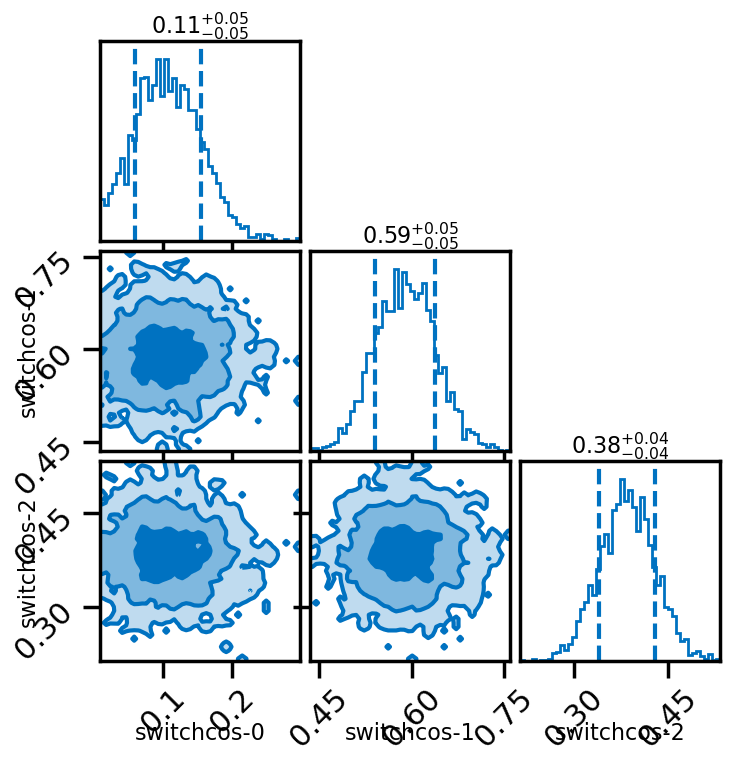

In [11]:
# Posterior of the mixing parameters.
result.plot_corner()

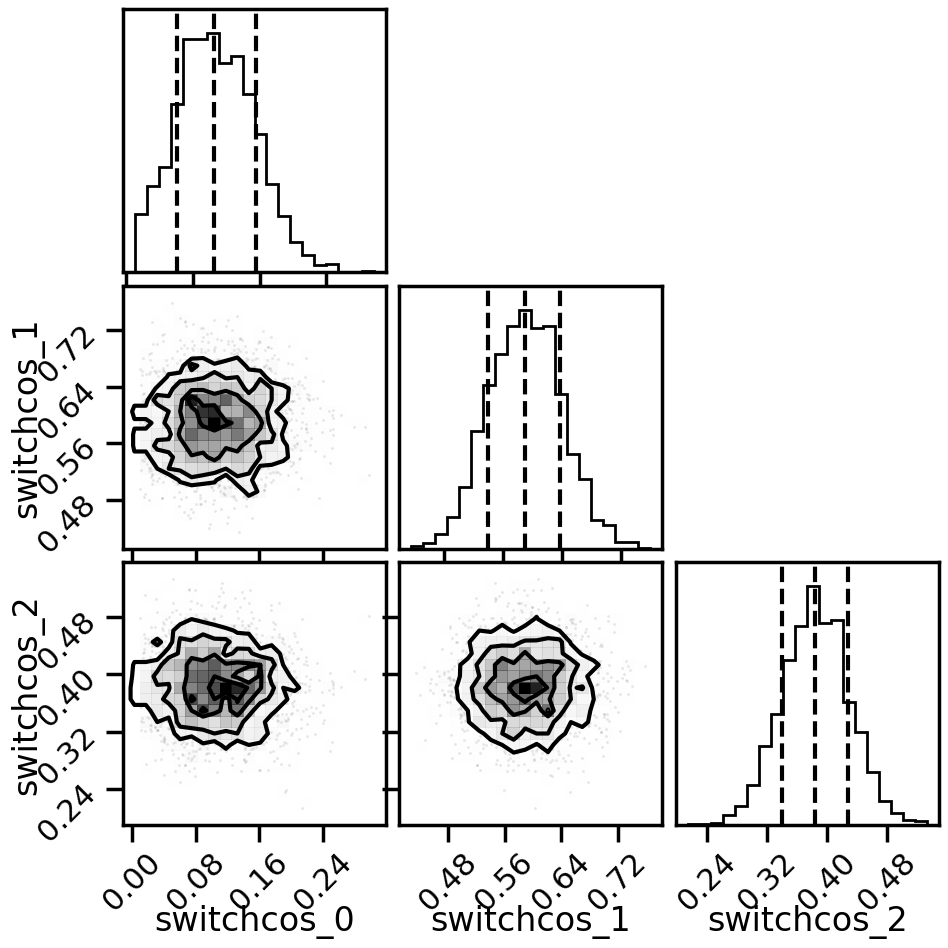

In [12]:
#corner plots
import corner
fig, axs = plt.subplots(3,3, figsize=(10,10), dpi=100)
corner.corner(mix_model.posterior,labels=['switchcos_0','switchcos_1', 'switchcos_2'],quantiles=[0.16, 0.5, 0.84],fig=fig)
plt.show()


## 4. Predictions

In [13]:
_,mean_prior,CI_prior, _ = mix_model.prior_predict(plot_g, CI=[5,20,80,95])
_,mean,CI, _ = mix_model.predict(plot_g, CI=[5,20,80,95])

(10000, 3)
using provided samples instead of posterior


In [14]:
per5, per20, per80, per95 = CI
prior5, prior20, prior80, prior95 = CI_prior

In [15]:
# Map value prediction for the step mixing function parameter
map_prediction = mix_model.evaluate(mix_model.map, plot_g)

In [16]:
_,_,CI_weights,_=mix_model.predict_weights(plot_g, CI=[5,20, 80, 95])
perw_5, perw_20, perw_80, perw_95 = CI_weights

(2600, 100)


In [17]:
prior_sample = np.array(list(priors.sample(5000).values())).T
_,_,CI_prior_weights,_=mix_model.predict_weights(plot_g, CI=[5,20, 80, 95], samples=prior_sample)
priorw_5, priorw_20, priorw_80, priorw_95 = CI_prior_weights

using provided samples instead of posterior
(5000, 100)


Text(0, 0.5, 'w')

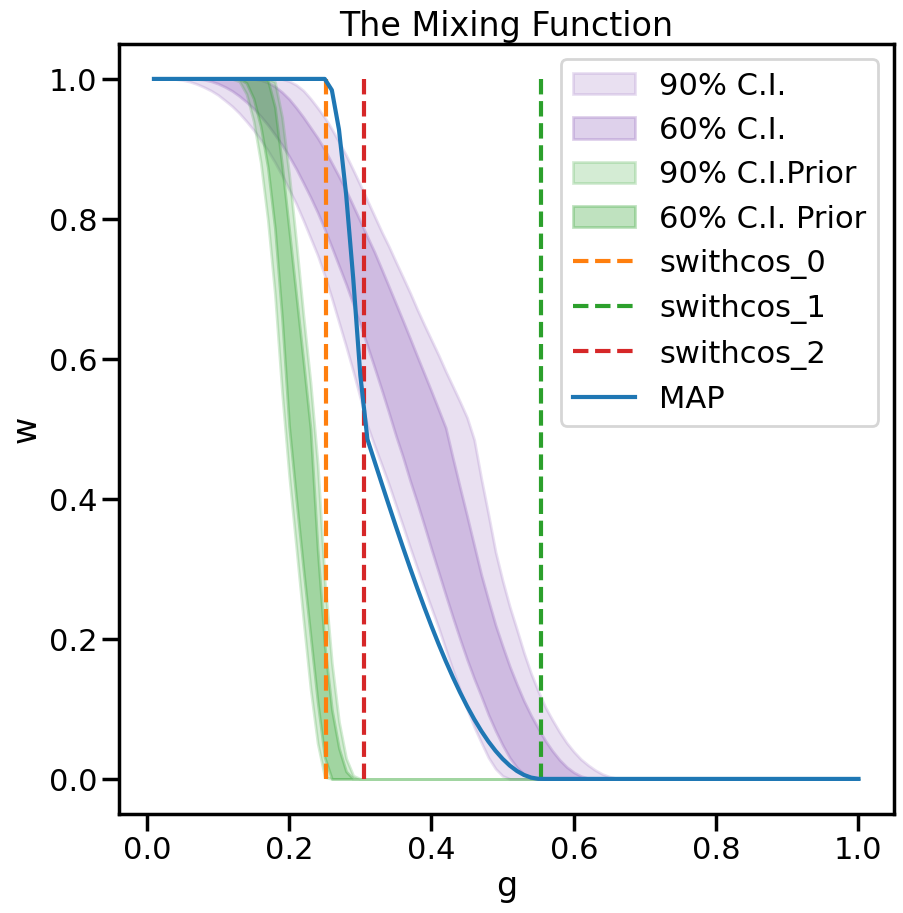

In [18]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,10))
ax.fill_between(plot_g,perw_5,perw_95,color=sns.color_palette()[4], alpha=0.2, label='90% C.I.')
ax.fill_between(plot_g,perw_20,perw_80, color=sns.color_palette()[4], alpha=0.3, label='60% C.I.')

ax.fill_between(plot_g,priorw_5,priorw_95,color=sns.color_palette()[2], alpha=0.2, label='90% C.I.Prior')
ax.fill_between(plot_g,priorw_20,priorw_80, color=sns.color_palette()[2], alpha=0.3, label='60% C.I. Prior')


w,_= mix_model.evaluate_weights(mix_model.map,plot_g)
ax.vlines(mix_model.map[0],0,1, linestyle='--', color=sns.color_palette()[1], label='swithcos_0')
ax.vlines(mix_model.map[1],0,1, linestyle='--', color=sns.color_palette()[2], label='swithcos_1')
ax.vlines(mix_model.map[2],0,1, linestyle='--', color=sns.color_palette()[3], label='swithcos_2')
ax.plot(plot_g, w, label='MAP')
ax.legend()
ax.set_title('The Mixing Function')
ax.set_xlabel('g')
ax.set_ylabel('w')

Text(0.5, 0, 'g')

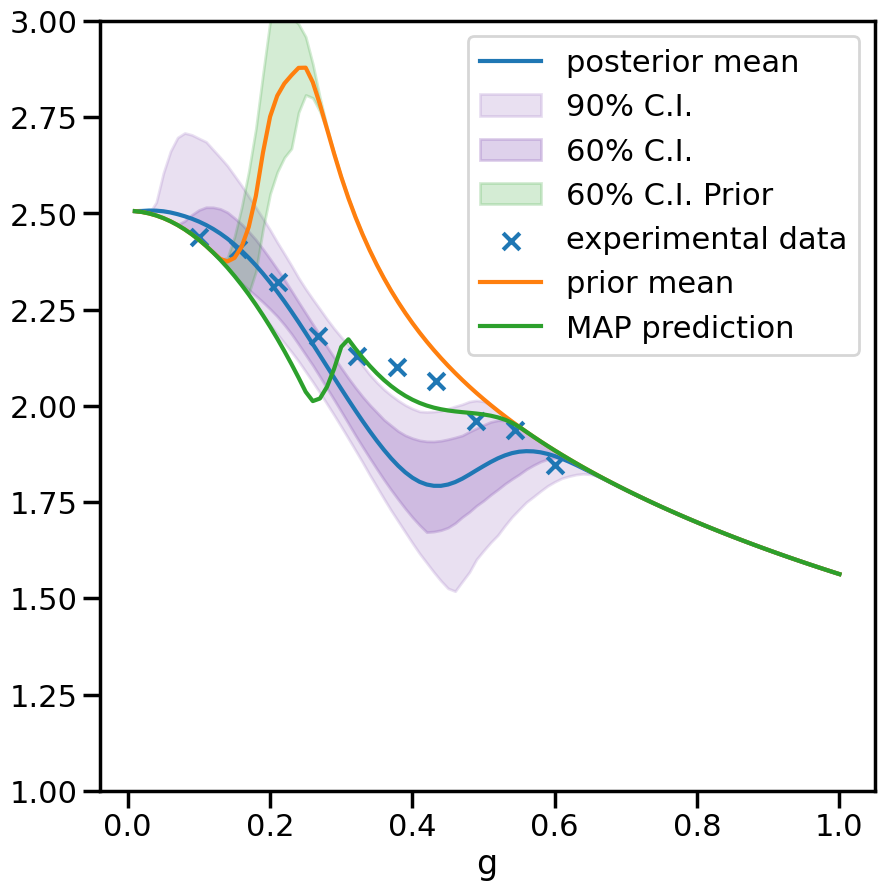

In [19]:
%matplotlib inline
sns.set_context('poster')
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(plot_g, mean.flatten(), label='posterior mean')
ax.fill_between(plot_g,per5.flatten(),per95.flatten(),color=sns.color_palette()[4], alpha=0.2, label='90% C.I.')
ax.fill_between(plot_g,per20.flatten(),per80.flatten(), color=sns.color_palette()[4], alpha=0.3, label='60% C.I.')
ax.fill_between(plot_g,prior20.flatten(),prior80.flatten(),color=sns.color_palette()[2], alpha=0.2, label='60% C.I. Prior')
ax.scatter(g,exp_data[0], marker='x', label='experimental data')
ax.plot(plot_g, mean_prior.flatten(), label='prior mean')
ax.plot(plot_g, map_prediction.flatten(), label='MAP prediction')
ax.set_ybound(1,3)
ax.legend()
ax.set_xlabel('g')